#                                      Breast Cancer Classification

## Attribute Information:

-  ID number 
- Diagnosis (M = malignant, B = benign)
- M is converted into 1, B is converted into 0


## Features that are computed for each cell nucleus:

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)

##  Importing libraries

In [1008]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


## Load the data

In [1009]:
df = pd.read_csv('data.csv')

In [1010]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Data Preprocessing

In [1011]:
df.drop(['id', 'Unnamed: 32'], axis = 1, inplace = True)

In [1012]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [1013]:
df['diagnosis'] = df['diagnosis'].apply(lambda val: 1 if val == 'M' else 0)

In [1014]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [1015]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [1016]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [1017]:
# checking for null values

df.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [1018]:
import pandas as pd
from scipy import stats
# Define a Z-score threshold for identifying outliers (e.g., Z-score > 3 or < -3)
z_score_threshold = 3

# Function to find outliers using Z-scores
def find_outliers_z_score(data_series):
    z_scores = np.abs(stats.zscore(data_series))
    outliers = data_series[z_scores > z_score_threshold]
    return outliers

# Iterate through columns and find outliers using Z-scores
outliers_per_column = {}
for column in df.columns:
    outliers = find_outliers_z_score(df[column])
    outliers_per_column[column] = outliers

# Print outliers for each column
for column, outliers in outliers_per_column.items():
    if not outliers.empty:
        print(f"Outliers in '{column}':")
        print(outliers)


Outliers in 'radius_mean':
82     25.22
180    27.22
212    28.11
352    25.73
461    27.42
Name: radius_mean, dtype: float64
Outliers in 'texture_mean':
219    32.47
232    33.81
239    39.28
259    33.56
Name: texture_mean, dtype: float64
Outliers in 'perimeter_mean':
82     171.5
122    166.2
180    182.1
212    188.5
352    174.2
461    186.9
521    165.5
Name: perimeter_mean, dtype: float64
Outliers in 'area_mean':
82     1878.0
122    1761.0
180    2250.0
212    2499.0
339    1747.0
352    2010.0
461    2501.0
521    1841.0
Name: area_mean, dtype: float64
Outliers in 'smoothness_mean':
3      0.14250
105    0.13980
122    0.14470
504    0.16340
568    0.05263
Name: smoothness_mean, dtype: float64
Outliers in 'compactness_mean':
0      0.2776
3      0.2839
78     0.3454
82     0.2665
108    0.2768
122    0.2867
181    0.2832
258    0.3114
567    0.2770
Name: compactness_mean, dtype: float64
Outliers in 'concavity_mean':
78     0.3754
82     0.3339
108    0.4264
122    0.4268
152  

In [1019]:
import pandas as pd
from scipy import stats

z_score_threshold = 3

# Function to find outliers using Z-scores and calculate the percentage of outliers
def find_outliers_z_score(data_series):
    z_scores = np.abs(stats.zscore(data_series))
    outliers = data_series[z_scores > z_score_threshold]
    percentage_outliers = (len(outliers) / len(data_series)) * 100
    return percentage_outliers

# Create a dictionary to store the percentage of outliers for each column
percentage_outliers_per_column = {}

# Iterate through columns and calculate the percentage of outliers using Z-scores
for column in df.columns:
    percentage_outliers = find_outliers_z_score(df[column])
    percentage_outliers_per_column[column] = percentage_outliers

# Print the percentage of outliers for each column
for column, percentage in percentage_outliers_per_column.items():
    print(f"Percentage of outliers in '{column}': {percentage:.2f}%")


Percentage of outliers in 'diagnosis': 0.00%
Percentage of outliers in 'radius_mean': 0.88%
Percentage of outliers in 'texture_mean': 0.70%
Percentage of outliers in 'perimeter_mean': 1.23%
Percentage of outliers in 'area_mean': 1.41%
Percentage of outliers in 'smoothness_mean': 0.88%
Percentage of outliers in 'compactness_mean': 1.58%
Percentage of outliers in 'concavity_mean': 1.58%
Percentage of outliers in 'concave points_mean': 1.05%
Percentage of outliers in 'symmetry_mean': 0.88%
Percentage of outliers in 'fractal_dimension_mean': 1.23%
Percentage of outliers in 'radius_se': 1.23%
Percentage of outliers in 'texture_se': 1.58%
Percentage of outliers in 'perimeter_se': 1.41%
Percentage of outliers in 'area_se': 1.05%
Percentage of outliers in 'smoothness_se': 1.23%
Percentage of outliers in 'compactness_se': 2.11%
Percentage of outliers in 'concavity_se': 1.05%
Percentage of outliers in 'concave points_se': 1.05%
Percentage of outliers in 'symmetry_se': 1.93%
Percentage of outlier

In [1020]:
df['diagnosis'].value_counts()/len(df['diagnosis'])*100

0    62.741652
1    37.258348
Name: diagnosis, dtype: float64

In [1021]:
df.groupby('diagnosis').mean()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
0,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
1,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,...,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530


In [1022]:
df.groupby('diagnosis').max()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
0,17.85,33.81,114.6,992.1,0.1634,0.2239,0.4108,0.08534,0.2743,0.09575,...,19.82,41.78,127.1,1210.0,0.2006,0.5849,1.252,0.175,0.4228,0.1486
1,28.11,39.28,188.5,2501.0,0.1447,0.3454,0.4268,0.20120,0.3040,0.09744,...,36.04,49.54,251.2,4254.0,0.2226,1.0580,1.170,0.291,0.6638,0.2075


In [1023]:
df.groupby('diagnosis').std()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
0,1.780512,3.995125,11.807438,134.287118,0.013446,0.033750,0.043442,0.015909,0.024807,0.006747,...,1.981368,5.493955,13.527091,163.601424,0.020013,0.092180,0.140368,0.035797,0.041745,0.013804
1,3.203971,3.779470,21.854653,367.937978,0.012608,0.053987,0.075019,0.034374,0.027638,0.007573,...,4.283569,5.434804,29.457055,597.967743,0.021870,0.170372,0.181507,0.046308,0.074685,0.021553


#### There are no missing values in the data. The Data has more number of benign case data

## Exploratory Data Analysis (EDA)

In [1024]:
col=list(df.columns)

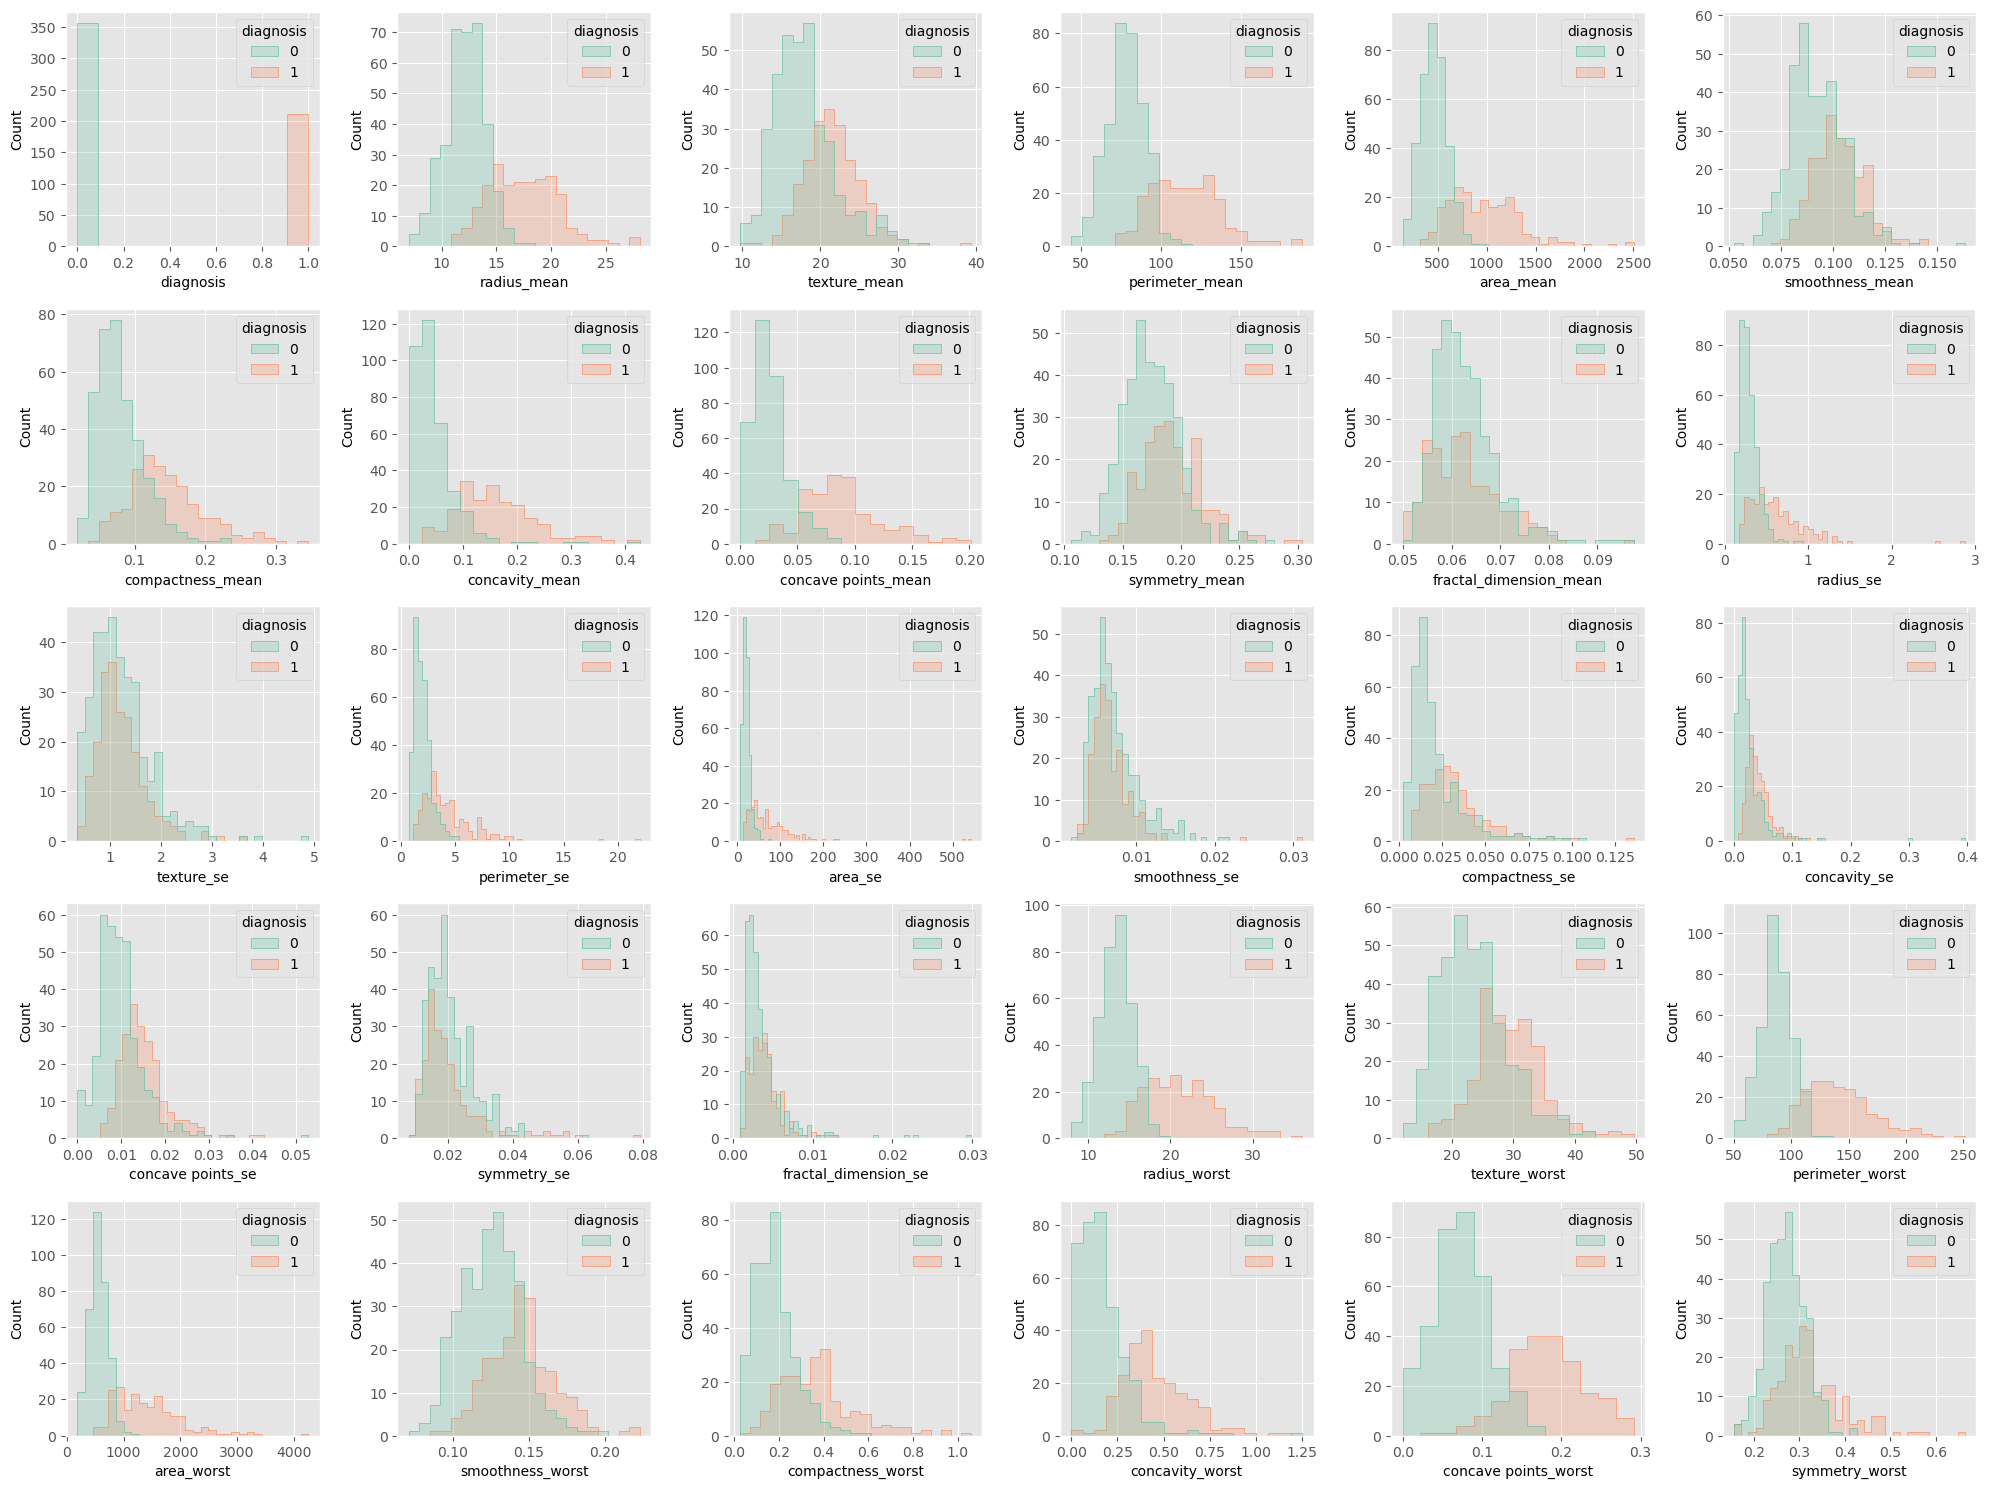

In [1025]:
plt.figure(figsize = (20, 15))

plotnumber = 1

for i in col:
    if plotnumber <= 30:
        ax = plt.subplot(5, 6, plotnumber)
        sns.histplot(data=df, x=i,hue=df['diagnosis'], multiple="layer", element="step", palette="Set2")
        plt.xlabel(i)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

    

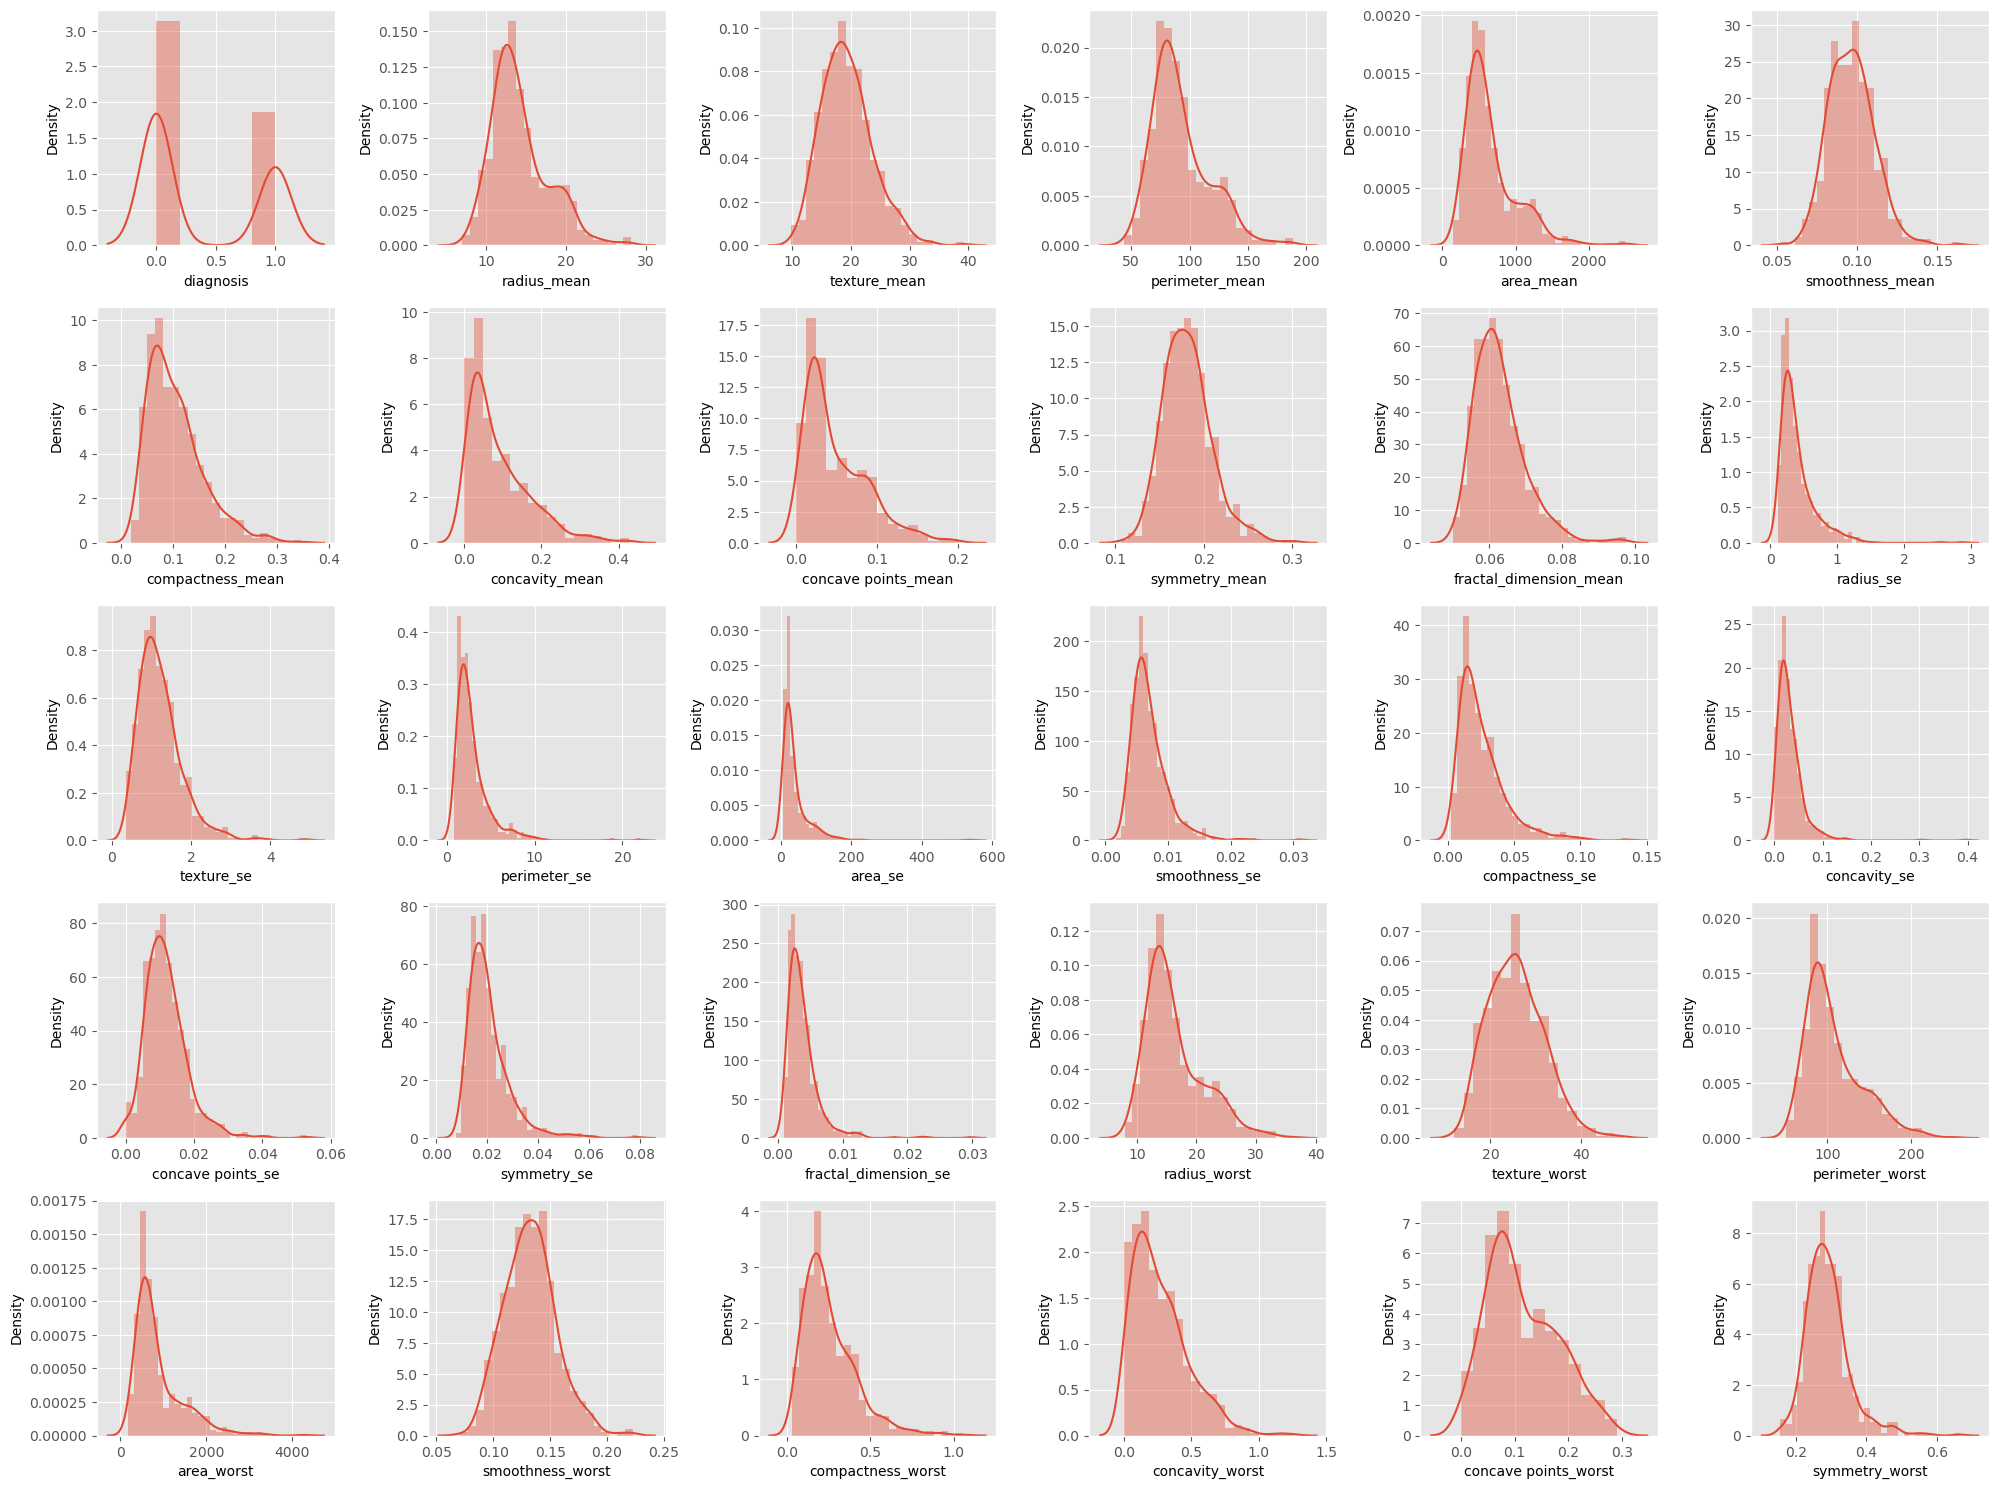

In [1026]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for column in df:
    if plotnumber <= 30:
        ax = plt.subplot(5, 6, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

In [1027]:
skewness = df.skew()
sque=[]

# the skewness for each column
for col in df.columns:
    s=skewness[col]
    sque.append(s) 
    print(f"Skewness for {col}: {skewness[col]:.4f}")
sque.sort()    




Skewness for diagnosis: 0.5285
Skewness for radius_mean: 0.9424
Skewness for texture_mean: 0.6504
Skewness for perimeter_mean: 0.9907
Skewness for area_mean: 1.6457
Skewness for smoothness_mean: 0.4563
Skewness for compactness_mean: 1.1901
Skewness for concavity_mean: 1.4012
Skewness for concave points_mean: 1.1712
Skewness for symmetry_mean: 0.7256
Skewness for fractal_dimension_mean: 1.3045
Skewness for radius_se: 3.0886
Skewness for texture_se: 1.6464
Skewness for perimeter_se: 3.4436
Skewness for area_se: 5.4472
Skewness for smoothness_se: 2.3145
Skewness for compactness_se: 1.9022
Skewness for concavity_se: 5.1105
Skewness for concave points_se: 1.4447
Skewness for symmetry_se: 2.1951
Skewness for fractal_dimension_se: 3.9240
Skewness for radius_worst: 1.1031
Skewness for texture_worst: 0.4983
Skewness for perimeter_worst: 1.1282
Skewness for area_worst: 1.8594
Skewness for smoothness_worst: 0.4154
Skewness for compactness_worst: 1.4736
Skewness for concavity_worst: 1.1502
Skewnes

In [1028]:
print(f"Maximum Skewness is {sque[-1]} Minimum Skewness is {sque[0]}")    

Maximum Skewness is 5.447186284898394 Minimum Skewness is 0.4154259962824678


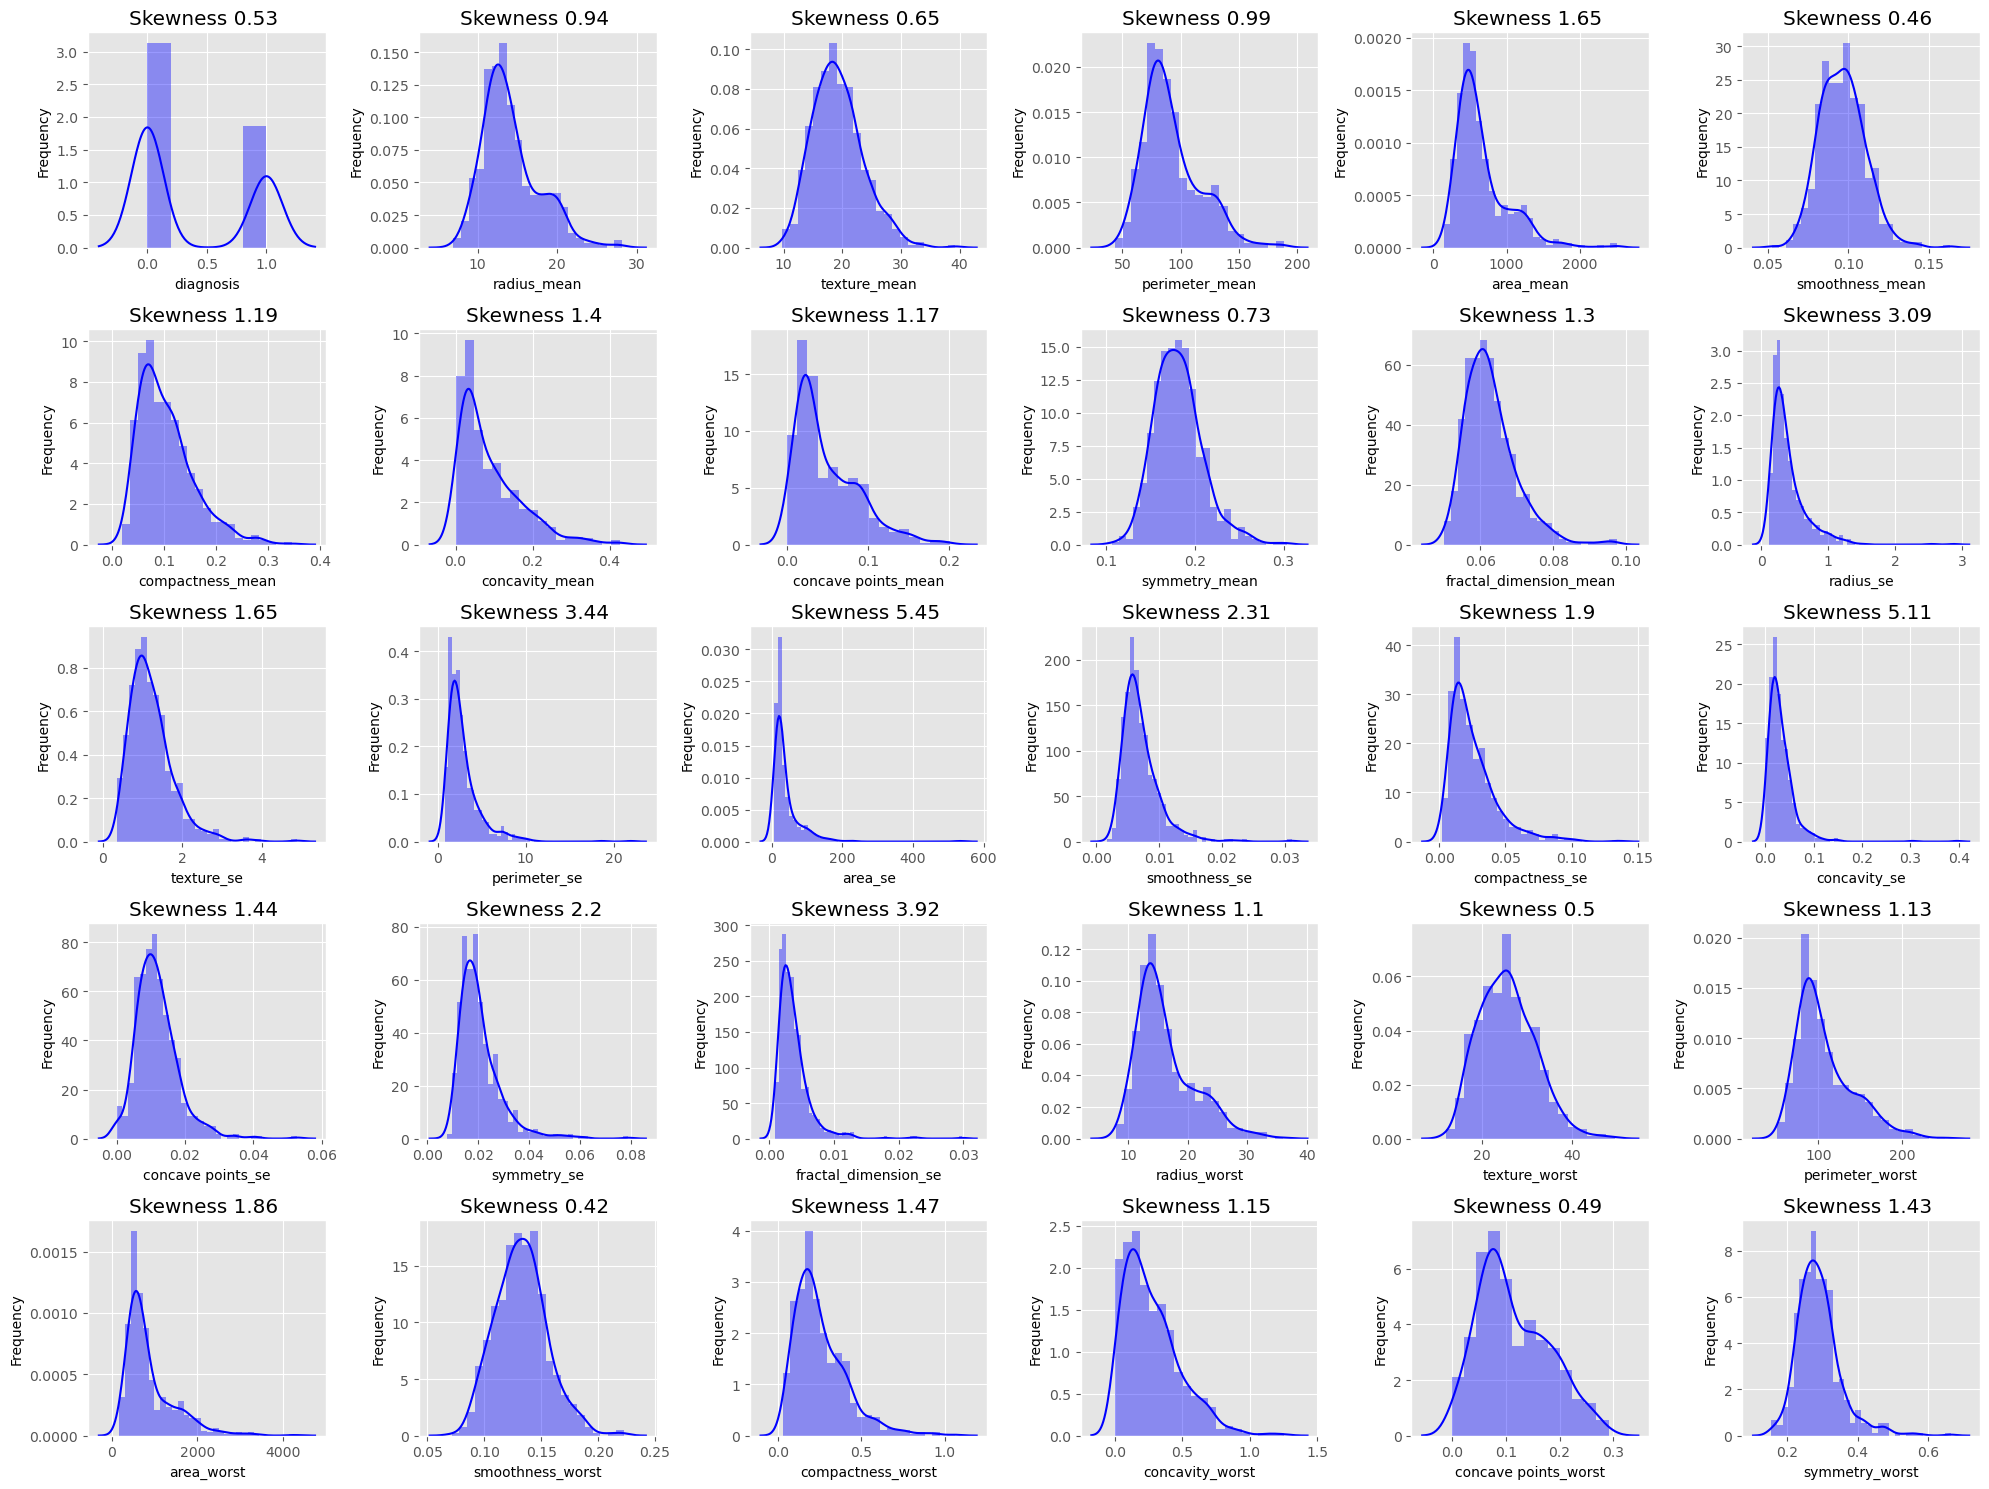

In [1029]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for column in df:
    if plotnumber <= 30:
        s=skewness[column]
        s=round(s,2)
        ax = plt.subplot(5, 6, plotnumber)
        sns.distplot(df[column], kde=True,color='b')
        plt.title(f'Skewness {s} ')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
    plotnumber += 1

plt.tight_layout()
plt.show()

In [1030]:
import scipy.stats as stats

k = stats.kurtosis(df, fisher=False)
l=[]
for i in k:
    i=round(i,2)
    l.append(i)
    
print(f"Kurtosis: {l}")
k.sort()


Kurtosis: [1.28, 3.83, 3.74, 3.95, 6.61, 3.84, 4.63, 4.97, 4.05, 4.27, 5.97, 20.52, 8.29, 24.2, 51.77, 13.37, 8.05, 51.42, 8.07, 10.82, 29.04, 3.93, 3.21, 4.05, 7.35, 3.5, 6.0, 4.59, 2.46, 7.4, 8.19]


In [1031]:
print(f"Mean kurtosis is {round(k.mean(),2)},Max kurtosis is {round(k.max(),2)}, Min kurtosis is {round(k.min(),2)} ")

Mean kurtosis is 10.43,Max kurtosis is 51.77, Min kurtosis is 1.28 


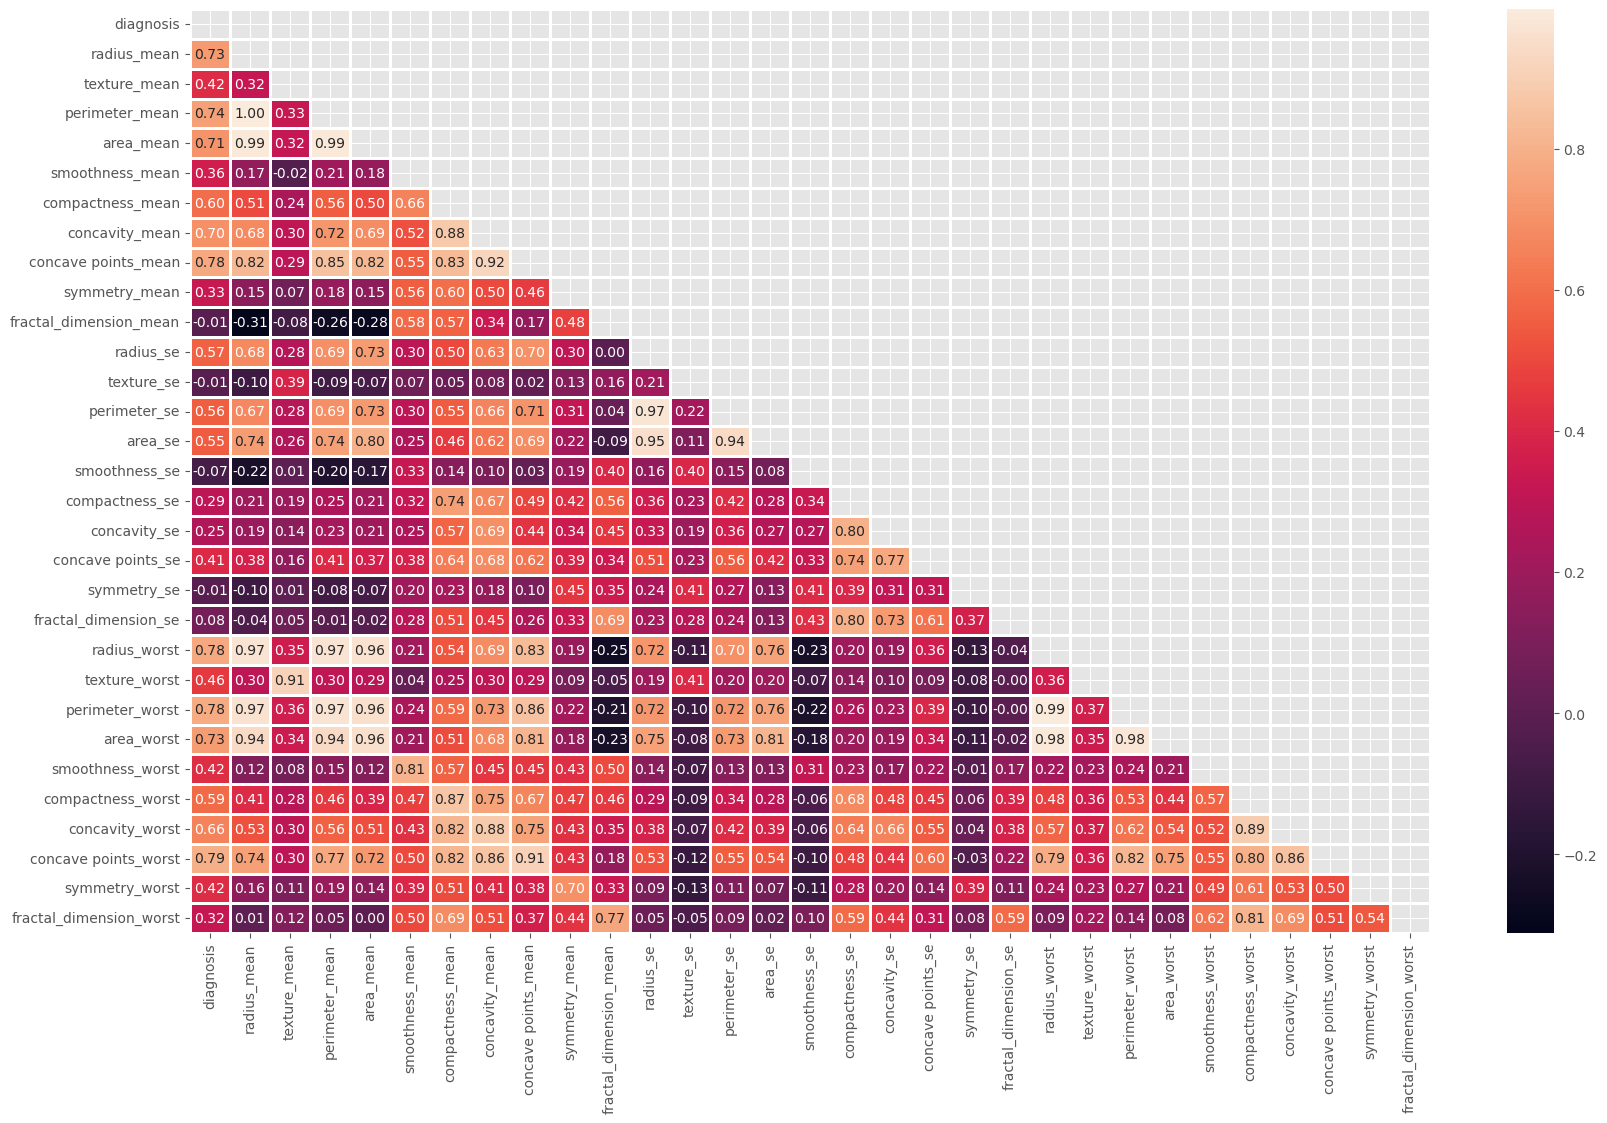

In [1032]:
# heatmap 

plt.figure(figsize = (20, 12))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(corr, mask = mask, linewidths = 1, annot = True, fmt = ".2f")
plt.show()

### We can see that there are many columns which are very highly correlated which causes multicollinearity so we need to handle highly correlated features.  

In [1033]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate the Variance Inflation Factor (VIF) for each feature
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Calculate VIF and print the results
vif_result = calculate_vif(df)
print("VIF results:")
print(vif_result)

# Identify and handle features with high VIF
high_vif_features = vif_result[vif_result["VIF"] > 10]["Feature"].tolist()
print("High VIF features:", high_vif_features)


VIF results:
                    Feature           VIF
0                 diagnosis      6.781264
1               radius_mean  63787.228031
2              texture_mean    251.122570
3            perimeter_mean  58217.307016
4                 area_mean   1305.508785
5           smoothness_mean    393.410071
6          compactness_mean    201.524726
7            concavity_mean    158.130682
8       concave points_mean    154.891431
9             symmetry_mean    184.542087
10   fractal_dimension_mean    654.870560
11                radius_se    237.352381
12               texture_se     24.675389
13             perimeter_se    211.429834
14                  area_se     72.669276
15            smoothness_se     26.395387
16           compactness_se     44.979263
17             concavity_se     33.676991
18        concave points_se     54.072023
19              symmetry_se     37.194742
20     fractal_dimension_se     27.556836
21             radius_worst   9960.892269
22            texture

In [1034]:
vif_result.mean()

VIF    4627.068261
dtype: float64

In [1035]:
import numpy as np
import pandas as pd

def find_outliers_iqr(data_series):
    # Calculate the IQR (Interquartile Range)
    Q1 = np.percentile(data_series, 25)
    Q3 = np.percentile(data_series, 75)
    IQR = Q3 - Q1

    # Define lower and upper bounds to identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = data_series[(data_series < lower_bound) | (data_series > upper_bound)]

    return outliers

# Find outliers in the VIF scores
vif_scores = vif_result["VIF"]
outliers = find_outliers_iqr(vif_scores)

# Print the outliers
print("Outliers in VIF scores:")
print(outliers)


Outliers in VIF scores:
1     63787.228031
3     58217.307016
4      1305.508785
21     9960.892269
23     4494.531141
24     1164.089106
Name: VIF, dtype: float64


In [1036]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to drop features with high VIF
def drop_high_vif_features(dataframe, threshold=1164.089106):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]

    # Get the names of features with high VIF
    high_vif_features = vif_data[vif_data["VIF"] > threshold]["Feature"].tolist()

    # Drop the high VIF features from the DataFrame
    dataframe = dataframe.drop(columns=high_vif_features)

    return dataframe

# Set the VIF threshold 
vif_threshold = 1164.089106

# Drop high VIF features and get the updated DataFrame
df = drop_high_vif_features(df, threshold=vif_threshold)




In [1121]:
len(df.columns)

25

In [1037]:
# creating features and label 
X=df.drop('diagnosis',axis=1)
y=df['diagnosis']

In [1038]:
X.head(2)

,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,...,concave points_se,symmetry_se,fractal_dimension_se,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,10.38,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,...,0.01587,0.03003,0.006193,17.33,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,17.77,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,...,0.01340,0.01389,0.003532,23.41,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [1039]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to replace outliers with the median in a DataFrame
def replace_outliers_with_median(dataframe, threshold=3):
    for column in dataframe.columns:
        z_scores = np.abs(stats.zscore(dataframe[column]))
        outliers = dataframe[column][z_scores > threshold]
        median = dataframe[column].median()
        dataframe[column][outliers.index] = median
    return dataframe

z_score_threshold = 3

# Replace outliers with median in the training data
X_train_no_outliers = replace_outliers_with_median(X_train, threshold=z_score_threshold)


In [1040]:
# scaling data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# K Neighbors Classifier (KNN)

In [1041]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

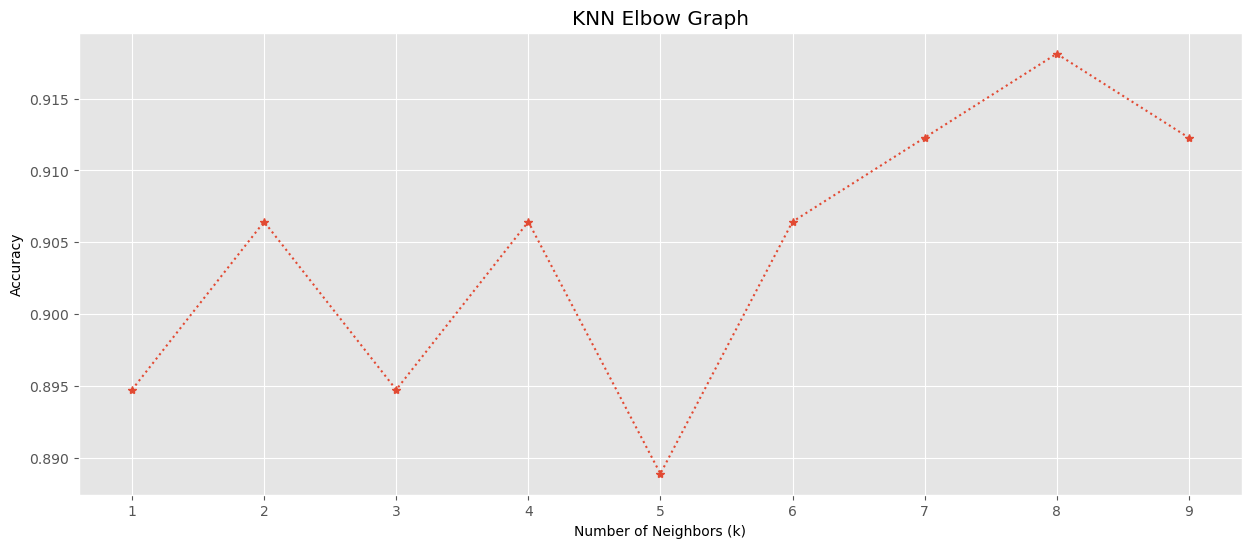

In [1042]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Range of k values to test
k_values = range(1, 10)

# Initialize lists to store accuracy scores for different k values
accuracy_scores = []

# Iterating through different k values and calculate accuracy
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)  # Predict on the test data
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the elbow graph
plt.figure(figsize=(15, 6))
plt.plot(k_values, accuracy_scores, marker='*', linestyle=':')
plt.title("KNN Elbow Graph")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [1043]:

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
knn_acc = accuracy_score(y_test, knn.predict(X_test))


print(f"Accuracy For 5 NN in testing data is {accuracy}") 

Accuracy For 5 NN in testing data is 0.8888888888888888


In [1044]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       108
           1       0.84      0.86      0.85        63

    accuracy                           0.89       171
   macro avg       0.88      0.88      0.88       171
weighted avg       0.89      0.89      0.89       171



In [1045]:
from sklearn.metrics import recall_score

rec_knn = recall_score(y_test, knn.predict(X_test))

print("Recall:", rec_knn)


Recall: 0.8571428571428571


# Decision Tree Classifier

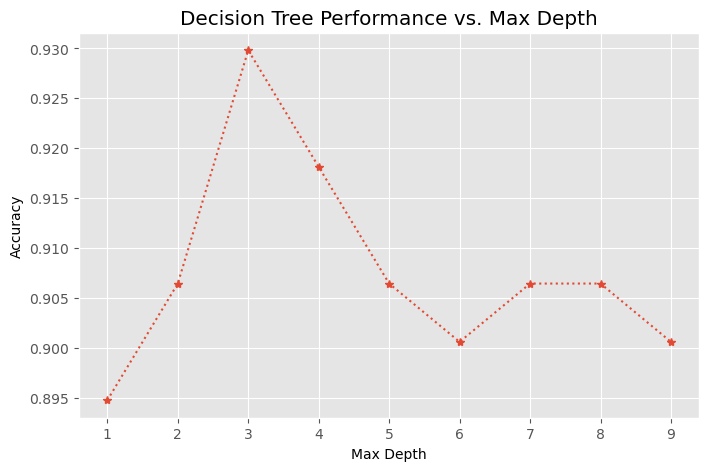

In [1046]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#  creating a decision tree performance graph
max_depths = range(1, 10)  
accuracy_scores = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)

    # Splitting  data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fiting the decision tree model
    dt.fit(X_train, y_train)

    # Evaluate model accuracy on the test set
    accuracy = dt.score(X_test, y_test)
    accuracy_scores.append(accuracy)

# Create a plot to visualize the results
plt.figure(figsize=(8, 5))
plt.plot(max_depths, accuracy_scores, marker='*',linestyle=':')
plt.title("Decision Tree Performance vs. Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [1073]:

dtc = DecisionTreeClassifier(criterion = 'gini',max_depth=3)

dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [1074]:
y_pred = dtc.predict(X_test)

In [1076]:
# accuracy score

print(accuracy_score(y_train, dtc.predict(X_train)))

dtc_acc = accuracy_score(y_test, dtc.predict(X_test))
print(dtc_acc)

0.9698492462311558
0.9298245614035088


In [1077]:
# confusion matrix

print(confusion_matrix(y_test, y_pred))

[[102   6]
 [  6  57]]


In [1078]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       108
           1       0.90      0.90      0.90        63

    accuracy                           0.93       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.93      0.93       171



In [1079]:
from sklearn.metrics import recall_score

rec_dt = recall_score(y_test, y_pred)

print("Recall:", rec_dt)


Recall: 0.9047619047619048


# Random Forest Classifier

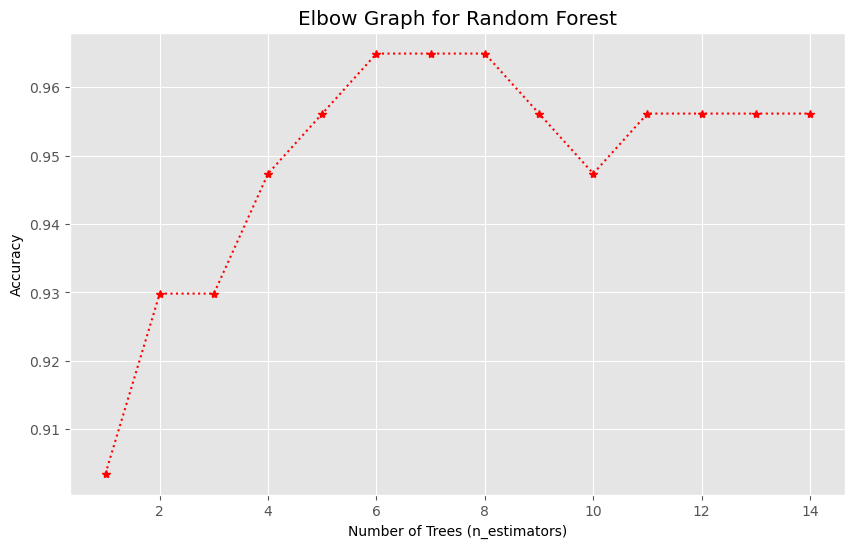

In [1080]:

from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of n_estimators
n_estimators_range = range(1, 15)  # You can adjust this range

# Initialize lists to store accuracy scores
accuracy_scores = []

# Iterate through different values of n_estimators
for n_estimators in n_estimators_range:
    # Create a Random Forest classifier with the current number of trees
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Fit the model to the training data
    rf.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = rf.predict(X_test)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Create an elbow plot to visualize the relationship between n_estimators and accuracy
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, marker='*', linestyle=':', color='r')
plt.title("Elbow Graph for Random Forest")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [1100]:
from sklearn.ensemble import RandomForestClassifier

rand_clf = RandomForestClassifier(n_estimators=6, random_state=42)
rand_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=6, random_state=42)

In [1101]:
y_pred = rand_clf.predict(X_test)

In [1103]:
# accuracy score

print(accuracy_score(y_train, rand_clf.predict(X_train)))

ran_clf_acc = accuracy_score(y_test, y_pred)
print(ran_clf_acc)

0.992462311557789
0.9122807017543859


In [1104]:
# confusion matrix

print(confusion_matrix(y_test, y_pred))

[[100   8]
 [  7  56]]


In [1105]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       108
           1       0.88      0.89      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171



In [1106]:
from sklearn.metrics import recall_score

rec_rand = recall_score(y_test, y_pred)

print("Recall:", rec_rand)


Recall: 0.8888888888888888


# Gradient Boosting Classifier

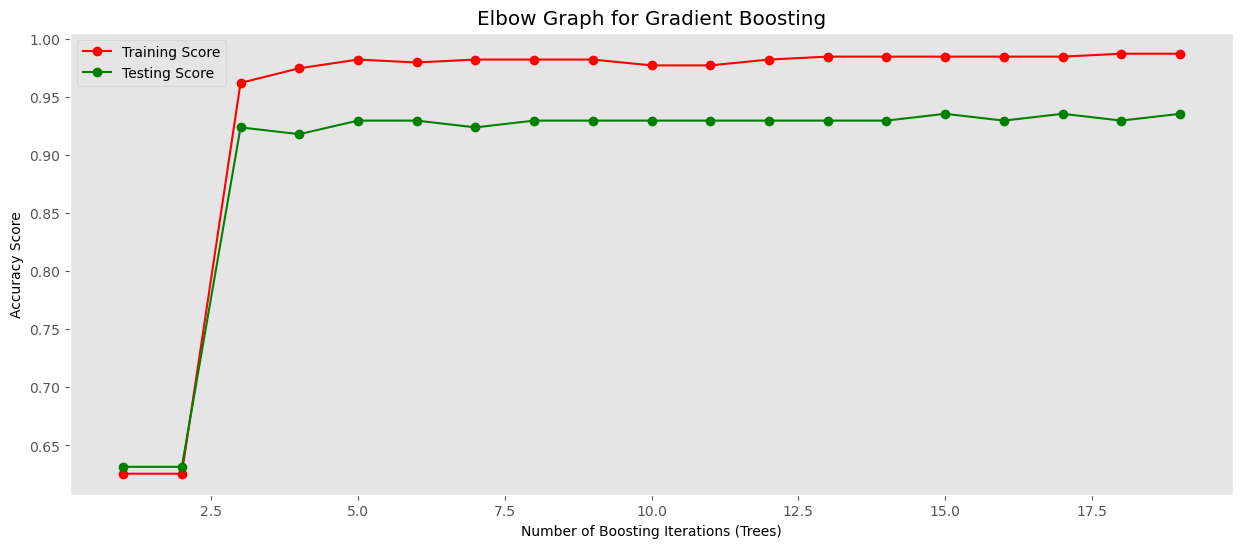

In [1107]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a range of boosting iterations (trees)
n_estimators_range = np.arange(1, 20)  # Adjust the range as needed

# Initialize empty lists to store the training and testing scores
train_scores = []
test_scores = []

# Iterate over the range of boosting iterations
for n_estimators in n_estimators_range:
    # Create and fit the Gradient Boosting Classifier
    gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    gb_classifier.fit(X_train, y_train)
    
    # Calculate the training and testing scores
    train_score = gb_classifier.score(X_train, y_train)
    test_score = gb_classifier.score(X_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

# Create an elbow graph to visualize the scores
plt.figure(figsize=(15, 6))
plt.plot(n_estimators_range, train_scores, marker='o', label='Training Score', color='red')
plt.plot(n_estimators_range, test_scores, marker='o', label='Testing Score', color='green')
plt.title('Elbow Graph for Gradient Boosting')
plt.xlabel('Number of Boosting Iterations (Trees)')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid()
plt.show()

In [1108]:

gbc = GradientBoostingClassifier()

GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train)
    
# Calculate the training and testing scores
train_score = gb_classifier.score(X_train, y_train)
test_score = gb_classifier.score(X_test, y_test)

print(f"Scores for GBC in trainning = {train_score} and testing = {test_score}")

Scores for GBC in trainning = 0.9874371859296482 and testing = 0.935672514619883


In [1109]:
gbc = GradientBoostingClassifier(learning_rate = .1, n_estimators = 130)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=130)

In [1110]:
y_pred = gbc.predict(X_test)

In [1111]:
# accuracy score

print(accuracy_score(y_train, gbc.predict(X_train)))

gbc_acc = accuracy_score(y_test, y_pred)
print(gbc_acc)

1.0
0.9532163742690059


In [1112]:
# confusion matrix

print(confusion_matrix(y_test, y_pred))

[[103   5]
 [  3  60]]


In [1113]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       108
           1       0.92      0.95      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



In [1114]:
from sklearn.metrics import recall_score

rec_gbm = recall_score(y_test, y_pred)

print("Recall:", rec_gbm)


Recall: 0.9523809523809523


# Extreme Gradient Boosting

In [1115]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


model = xgb.XGBClassifier()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


xgb_acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {xgb_acc:.2f}')
xgb_acc=xgb_acc


Accuracy: 0.96


In [1116]:
# confusion matrix

print(confusion_matrix(y_test, y_pred))

[[104   4]
 [  2  61]]


In [1117]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       108
           1       0.94      0.97      0.95        63

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171



In [1118]:
from sklearn.metrics import recall_score

rec_xgb = recall_score(y_test, y_pred)

print("Recall:", rec_xgb)


Recall: 0.9682539682539683


In [1119]:
models = pd.DataFrame({
    'Model': ['KNN',  'Decision Tree Classifier', 'Random Forest Classifier',
             'Gradient Boosting Classifier',  'XgBoost'],
    'Score': [ knn_acc*100, dtc_acc*100, ran_clf_acc*100,  gbc_acc*100,  xgb_acc*100],
    "Recall" :[rec_knn*100,rec_dt*100,rec_rand*100,rec_gbm*100,rec_xgb*100]
})

models.sort_values(by = 'Recall', ascending = False)

,Model,Score,Recall
4,XgBoost,96.491228,96.825397
3,Gradient Boosting Classifier,95.321637,95.238095
1,Decision Tree Classifier,92.982456,90.476190
2,Random Forest Classifier,91.228070,88.888889
0,KNN,88.888889,85.714286


## Best model for diagnosing breast cancer is "XgBoost" with an accuracy of  96.491228%. and recall of  96.825397%